# Hotel booking cancellation prediction
Authors:
* DAU Hai Dang
* Le Ha Quang
* TRAN Duc Dung

In [12]:
#Install if necessary
#!pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master

In [12]:
import numpy as np
import problem
import pandas as pd
import seaborn as sns
%matplotlib inline

## Table of content
1. [Introduction](#ph1)
2. [Exploratory Data Analysis](#ph2)
3. [Workflow](#ph3)
4. [Submission](#ph4)

## Introduction <a name="ph1"></a>

**QUANG/DUNG: Please write the introduction**

### KPI and Metric

If the hotel predicts that a customer's reservation is likely to be canceled, the reception has the following solutions:
* It can either ask for more guarantee from the concerned customer, for example, by asking for a higher deposit fee.
* It can also allow other customers to be on the waitlist for the room/time slot that the likely-to-cancel customer reserved.
If the prediction is that the customer's reservation is canceled but it turns out that the customer does not cancel the reservation (false positive), there is a potential cost A for the hotel. If it demanded stricter guarantees from the customer, the customer might feel that the hotel did not trust him, especially if he is a returning customer. If it allowed other customers to be on the waitlist without finally being able to accomodate their reservations, it might create some hope, followed by ultimate frustration on these customers.

If the prediction is that the customer's reservation is not canceled but in fact it is canceled (false negative), there is a clear cost B for the hotel, because the hotel did not take any preventive actions.

From a business point of view, it is reasonable that the cost B is normally higher than the cost A. In other words, the recall score is more important than the precision score.

To reflect this, we use a Modified F1 metric (abbreviated mf1 below), where the precision's weight is 1 and the recall's weight is 3.

## Explanatory data analysis <a name="ph2"></a>

**QUANG/ DUNG:Please focus on this, important part!!!** Draw as many graphs as possible, talk as much as possible.

In [2]:
data = pd.read_csv('data/train.csv')
data.head()

,IsCanceled,LeadTime,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,...,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
0,0,187,July,28,9,2,5,2,0,0,...,A,0,No Deposit,240,NULL,0,Transient,83.00,0,2
1,1,0,September,37,9,0,1,1,0,0,...,F,0,No Deposit,NULL,NULL,0,Transient,146.00,0,2
2,1,156,September,36,2,2,5,2,0,0,...,E,0,No Deposit,171,NULL,0,Transient,98.00,0,0
3,0,5,December,51,19,0,1,2,0,0,...,D,0,No Deposit,NULL,NULL,0,Transient-Party,43.00,0,1
4,0,3,October,41,8,0,3,2,0,0,...,D,0,No Deposit,250,NULL,0,Transient,73.67,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32048 entries, 0 to 32047
Data columns (total 28 columns):
IsCanceled                     32048 non-null int64
LeadTime                       32048 non-null int64
ArrivalDateMonth               32048 non-null object
ArrivalDateWeekNumber          32048 non-null int64
ArrivalDateDayOfMonth          32048 non-null int64
StaysInWeekendNights           32048 non-null int64
StaysInWeekNights              32048 non-null int64
Adults                         32048 non-null int64
Children                       32048 non-null int64
Babies                         32048 non-null int64
Meal                           32048 non-null object
Country                        31677 non-null object
MarketSegment                  32048 non-null object
DistributionChannel            32048 non-null object
IsRepeatedGuest                32048 non-null int64
PreviousCancellations          32048 non-null int64
PreviousBookingsNotCanceled    32048 non-null int64
Re

We see that there is no missing data, except in the Country column. We can therefore fill all missing data with -1.

In [5]:
data = data.fillna(-1)

Let us now see how many categories each categorical variable has.

In [6]:
cat_cols = [col for col in data.columns if str(data[col].dtype) == 'object']
no_cats = [len(set(data[col])) for col in cat_cols]
pd.DataFrame({'Column': cat_cols, 'Number of categories': no_cats})

,Column,Number of categories
0,ArrivalDateMonth,12
1,Meal,5
2,Country,118
3,MarketSegment,6
4,DistributionChannel,4
5,ReservedRoomType,10
6,AssignedRoomType,11
7,DepositType,3
8,Agent,178
9,Company,226


For numerical or binary variables, the **describe** function provides valuable insights.

In [7]:
data.describe()

,IsCanceled,LeadTime,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
count,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000
mean,0.276804,92.450012,27.088492,15.802733,1.186252,3.124282,1.866232,0.128838,0.013885,0.044496,0.099663,0.150743,0.289066,0.525119,95.043906,0.138698,0.618198
std,0.447426,97.066314,13.978094,8.892396,1.143512,2.444580,0.683958,0.444471,0.118869,0.206197,1.325955,1.027454,0.727221,7.388141,61.556252,0.352785,0.813272
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,10.000000,15.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000
50%,0.000000,57.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000,0.000000
75%,1.000000,154.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.000000,0.000000,1.000000
max,1.000000,737.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,2.000000,1.000000,26.000000,28.000000,17.000000,185.000000,450.000000,8.000000,5.000000


Some first observations:
* The problem is imbalanced (because mean of IsCanceled is 0.28). This is confirmed by the plot below
* This hotel is very busy. Mean of LeadTime is 92.5, which means that most bookings take place in average 90 days before arrival time. This makes cancellation prediction problem very important from a business point of view.
* Mean of IsRepeatedGuest is 0.04, so most guests are in fact new ones. Again, this means that cancellation prediction is an important problem for this hotel.

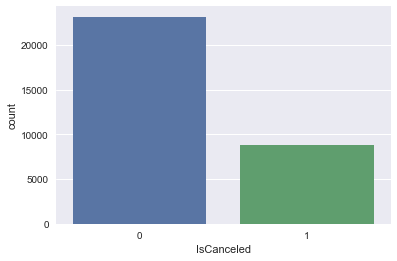

In [13]:
sns.countplot(x = 'IsCanceled', data = data)

## Workflow <a name="ph3"></a>

The workflow is: Feature Extractor + Classifier. [QUANG/DUNG :add a picture of the workflow here].

The difficulty is that there are categorical variables, and each subset of the train set (that is created for example by the cross validation procedure) may not contain all the categories of a categorical variables. The challenge is thus to write a **transform** function which produces an array of consistent sizes, even if **transform** is applied to a subset of the train set. Here **transform** just remove all categorical variables.

QUANG/DUNG: If you have time, please write a less stupid feature_extractor and classifier. Do not change the starting_kit but rather create a new kit.

In [3]:
%%file submissions/starting_kit/feature_extractor.py
import pandas as pd
class FeatureExtractor:
    def __init__(self):
        pass
    
    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):
        # simple solution: drop all numeric columns
        X_df_2 = X_df.fillna(-1)
        non_numeric_columns = ['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType']
        X_df_2 = X_df_2.drop(labels = non_numeric_columns, axis = 1)
        temp = X_df_2.values
        assert(str(temp.dtype) != 'object')
        return temp

Overwriting submissions/starting_kit/feature_extractor.py


In [4]:
%%file submissions/starting_kit/classifier.py
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

class Classifier(BaseEstimator):
    def __init__(self):
        self.model = make_pipeline(StandardScaler(), LogisticRegression())
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

Overwriting submissions/starting_kit/classifier.py


## Submission <a name="ph4"></a>

In [5]:
!ramp_test_submission --submission starting_kit

Testing Hotel booking cancellation prediction
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
/Users/haidang/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
	score   mf1  prec   rec
	train  0.31  0.66  0.27
	valid  0.31  0.68  0.26
	test   0.31  0.65  0.26
CV fold 1
/Users/haidang/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
	score   mf1  prec   rec
	train  0.32  0.67  0.27
	valid  0.33  0.65  0.28
	test   0.32  0.66  0.28
CV fold 2
/Users/haidang/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warni